<a href="https://colab.research.google.com/github/jianzhiw/spaCy/blob/master/inshorts_NLP_Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scraping News Articles for Data Retrieval #
We will be scraping [inshorts](https://inshorts.com/), the website, by leveraging python to retrieve news articles. We will be focusing on articles on technology, sports and world affairs. We will retrieve one page’s worth of articles for each category. A typical news category landing page is depicted in the following figure, which also highlights the HTML section for the textual content of each article.


In [1]:
# Install library
!pip install contractions
!pip install textsearch

# Download spaCy Model
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


Go to RunTime -> restart runtime and start running from the code below. 

In [0]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re

import contractions
import unicodedata
%matplotlib inline

In [0]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [3]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,OnePlus 7 Pro available with exchange offer on...,The recently launched OnePlus 7 Pro is availab...,technology
1,"Trump criticises Sundar Pichai, says 'We're wa...",US President Donald Trump on Tuesday took to T...,technology
2,Researchers demo way to fool Apple's Face ID f...,Tencent Security researchers at the 2019 Black...,technology
3,TikTok owner ByteDance plans to launch search ...,Short-video app TikTok's Chinese owner ByteDan...,technology
4,"Gun parts still listed on Amazon, Google despi...",Gun parts and accessories are still being list...,technology
5,Knives sold on FB without age check despite ba...,Knives are being sold on Facebook's e-commerce...,technology
6,"Hong Kong protesters using Tinder, Pokémon Go ...",Protestors in Hong Kong are using dating platf...,technology
7,Instagram ad partner tracked millions of users...,A marketing partner for Facebook and Instagram...,technology
8,WhatsApp bugs can let hackers alter chats: IT ...,Israeli cybersecurity firm Check Point has cla...,technology
9,Snap looks to raise $1 bn via new proposed pri...,Snap has announced a new proposed private offe...,technology


In [4]:
news_df.news_category.value_counts()

world         25
sports        25
technology    25
Name: news_category, dtype: int64

In [5]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('conll2000')
nlp = spacy.load('en_core_web_lg', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.


# Removing HTML tags #
Often, unstructured text contains a lot of noise, especially if you use techniques like web or screen scraping. HTML tags are typically one of these components which don’t add much value towards understanding and analyzing text.

In [0]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

# Removing accented characters #
Usually in any text corpus, you might be dealing with accented characters/letters, especially if you only want to analyze the English language. Hence, we need to make sure that these characters are converted and standardized into ASCII characters. A simple example — converting é to e.

In [0]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

# Expanding contraction #

Contractions are shortened version of words or syllables. They often exist in either written or spoken forms in the English language. These shortened versions or contractions of words are created by removing specific letters and sounds. In case of English contractions, they are often created by removing one of the vowels from the word. Examples would be, **do not** to **don’t** and **I would** to **I’d**. Converting each contraction to its expanded, original form helps with text standardization.

Contractions library can do this without the need of defining formula.

In [8]:
text = "Wouldn't it be great if he's able to join yall?"
contractions.fix(text)

'would not it be great if he is able to join you all?'

# Removing Special Characters #
Special characters and symbols are usually non-alphanumeric characters or even occasionally numeric characters (depending on the problem), which add to the extra noise in unstructured text. Usually, simple regular expressions (regexes) can be used to remove them.


In [0]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

# Stemming #
To understand stemming, you need to gain some perspective on what word stems represent. Word stems are also known as the base form of a word, and we can create new words by attaching affixes to them in a process known as inflection. Consider the word **JUMP**. You can add affixes to it and form new words like **JUMPS**, **JUMPED**, and **JUMPING**. In this case, the base word **JUMP** is the word stem.

In [0]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text


# Lemmatization #
Lemmatization is very similar to stemming, where we remove word affixes to get to the base form of a word. However, the base form in this case is known as the root word, but not the root stem. The difference being that the root word is always a lexicographically correct word (present in the dictionary), but the root stem may not be so. Thus, root word, also known as the lemma, will always be present in the dictionary. Both nltk and spacy have excellent lemmatizers. We will be using spacy here.


In [0]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

# Removing Stopwords #
Words which have little or no significance, especially when constructing meaningful features from text, are known as stopwords or stop words. These are usually words that end up having the maximum frequency if you do a simple term or word frequency in a corpus. Typically, these can be articles, conjunctions, prepositions and so on. Some examples of stopwords are **a**, **an**, **the**, **and**.

In [0]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Bringing it all together — Building a Text Normalizer #
While we can definitely keep going with more techniques like correcting spelling, grammar and so on, let’s now bring everything we learnt together and chain these operations to build a text normalizer to pre-process text data.

In [0]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = contractions.fix(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [14]:
# combining headline and article text
news_df['full_text'] = news_df["news_headline"].map(str)+ '. ' + news_df["news_article"]

# pre-process text and store the same
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])

# show a sample news article
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'clean_text': 'trump criticise sundar pichai say watch google closely us president donald trump tuesday take twitter criticise google ceo sundar pichai add white house work hard explain much like trump add former google engineer kevin cernekee say google want make sure trump lose us election watch google closely trump add',
 'full_text': 'Trump criticises Sundar Pichai, says \'We\'re watching Google closely\'. US President Donald Trump on Tuesday took to Twitter to criticise Google CEO Sundar Pichai adding that he was at the White House "working very hard to explain how much he liked me".Trump added that former Google engineer Kevin Cernekee said that Google wants to make sure Trump loses 2020 US elections. "We are watching Google very closely!" Trump added.'}

dataset to csv

In [0]:
news_df.to_csv('news.csv', index=False, encoding='utf-8')

# Tagging Parts of Speech #
Parts of speech (POS) are specific lexical categories to which words are assigned, based on their syntactic context and role. Usually, words can fall into one of the following major categories.
* N(oun): This usually denotes words that depict some object or entity, which may be living or nonliving. Some examples would be fox , dog , book , and so on. The POS tag symbol for nouns is N.
* V(erb): Verbs are words that are used to describe certain actions, states, or occurrences. There are a wide variety of further subcategories, such as auxiliary, reflexive, and transitive verbs (and many more). Some typical examples of verbs would be running , jumping , read , and write . The POS tag symbol for verbs is V.
* Adj(ective): Adjectives are words used to describe or qualify other words, typically nouns and noun phrases. The phrase beautiful flower has the noun (N) flower which is described or qualified using the adjective (ADJ) beautiful . The POS tag symbol for adjectives is ADJ .
* Adv(erb): Adverbs usually act as modifiers for other words including nouns, adjectives, verbs, or other adverbs. The phrase very beautiful flower has the adverb (ADV) very , which modifies the adjective (ADJ) beautiful , indicating the degree to which the flower is beautiful. The POS tag symbol for adverbs is ADV.
<br></br>

Besides these four major categories of parts of speech , there are other categories that occur frequently in the English language. These include pronouns, prepositions, interjections, conjunctions, determiners, and many others. Furthermore, each POS tag like the noun (N) can be further subdivided into categories like singular nouns (NN), singular proper nouns (NNP), and plural nouns (NNS).
<br></br>
The process of classifying and labeling POS tags for words called parts of speech tagging or POS tagging . POS tags are used to annotate words and depict their POS, which is really helpful to perform specific analysis, such as narrowing down upon nouns and seeing which ones are the most prominent, word sense disambiguation, and grammar analysis. We will be leveraging both nltk and spacy which usually use the Penn Treebank notation for POS tagging.

In [0]:
# create a basic pre-processed corpus, don't lowercase to get POS context
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

# demo for POS tagging for sample news headline
sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)


In [17]:
# POS tagging with Spacy 
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])


,Word,POS tag,Tag type
0,Trump,NNP,PROPN
1,criticises,VBZ,VERB
2,Sundar,NNP,PROPN
3,Pichai,NNP,PROPN
4,",",",",PUNCT
5,says,VBZ,VERB
6,',``,PUNCT
7,We,PRP,PRON
8,'re,VBP,VERB
9,watching,VBG,VERB


In [18]:
# POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

,Word,POS tag
0,Trump,NN
1,criticises,NNS
2,Sundar,NNP
3,"Pichai,",NNP
4,says,VBZ
5,'We're,CD
6,watching,VBG
7,Google,NNP
8,closely',NN


# Shallow Parsing or Chunking #
Based on the hierarchy we depicted earlier, groups of words make up phrases. There are five major categories of phrases:
* Noun phrase (NP): These are phrases where a noun acts as the head word. Noun phrases act as a subject or object to a verb.
* Verb phrase (VP): These phrases are lexical units that have a verb acting as the head word. Usually, there are two forms of verb phrases. One form has the verb components as well as other entities such as nouns, adjectives, or adverbs as parts of the object.
* Adjective phrase (ADJP): These are phrases with an adjective as the head word. Their main role is to describe or qualify nouns and pronouns in a sentence, and they will be either placed before or after the noun or pronoun.
* Adverb phrase (ADVP): These phrases act like adverbs since the adverb acts as the head word in the phrase. Adverb phrases are used as modifiers for nouns, verbs, or adverbs themselves by providing further details that describe or qualify them.
* Prepositional phrase (PP): These phrases usually contain a preposition as the head word and other lexical components like nouns, pronouns, and so on. These act like an adjective or adverb describing other words or phrases.
<br></br>

Shallow parsing, also known as light parsing or chunking , is a popular natural language processing technique of analyzing the structure of a sentence to break it down into its smallest constituents (which are tokens such as words) and group them together into higher-level phrases. This includes POS tags as well as phrases from a sentence.

We will leverage the **conll2000** corpus for training our shallow parser model. This corpus is available in nltk with chunk annotations and we will be using around 10K records for training our model. A sample annotated sentence is depicted as follows.

In [19]:
from nltk.corpus import conll2000

data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:] 

print(len(train_data), len(test_data))
print(train_data[1]) 

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


From the preceding output, you can see that our data points are sentences that are already annotated with phrases and POS tags metadata that will be useful in training our shallow parser model. We will leverage two chunking utility functions, tree2conlltags , to get triples of word, tag, and chunk tags for each token, and conlltags2tree to generate a parse tree from these token triples. We will be using these functions to train our parser. A sample is depicted below.

In [20]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

The chunk tags use the IOB format. This notation represents Inside, Outside, and Beginning. The B- prefix before a tag indicates it is the beginning of a chunk, and I- prefix indicates that it is inside a chunk. The O tag indicates that the token does not belong to any chunk. The B- tag is always used when there are subsequent tags of the same type following it without the presence of O tags between them.
<br></br>
We will now define a function **conll_tag_ chunks()** to extract POS and chunk tags from sentences with chunked annotations and a function called **combined_taggers()** to train multiple taggers with backoff taggers (e.g. unigram and bigram taggers)

In [0]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

We will now define a class **NGramTagChunker** that will take in tagged sentences as training input, get their (word, POS tag, Chunk tag) WTC triples, and train a BigramTagger with a UnigramTagger as the backoff tagger. We will also define a **parse()** function to perform shallow parsing on new sentences

>The **UnigramTagger** , **BigramTagger** , and **TrigramTagger** are classes that inherit from the base class **NGramTagger**, which itself inherits from the **ContextTagger class**, which inherits from the **SequentialBackoffTagger** class.

We will use this class to train on the **conll2000** chunked **train_data** and evaluate the model performance on the **test_data**

In [22]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

# define the chunker class
class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    if not tagged_sentence: 
        return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)
  
# train chunker model  
ntc = NGramTagChunker(train_data)

# evaluate chunker model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [23]:
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP Trump/NN criticises/NNS Sundar/NNP Pichai,/NNP)
  (VP says/VBZ)
  (NP 'We're/CD watching/VBG Google/NNP closely'/NN))


# Constituency Parsing #
Constituent-based grammars are used to analyze and determine the constituents of a sentence. These grammars can be used to model or represent the internal structure of sentences in terms of a hierarchically ordered structure of their constituents. Each and every word usually belongs to a specific lexical category in the case and forms the head word of different phrases. These phrases are formed based on rules called phrase structure rules.
<br></br>
Phrase structure rules form the core of constituency grammars, because they talk about syntax and rules that govern the hierarchy and ordering of the various constituents in the sentences. These rules cater to two things primarily.
* They determine what words are used to construct the phrases or constituents.
* They determine how we need to order these constituents together.
<br></br>

The generic representation of a phrase structure rule is S → AB , which depicts that the structure S consists of constituents A and B , and the ordering is A followed by B . While there are several rules (refer to Chapter 1, Page 19: Text Analytics with Python, if you want to dive deeper), the most important rule describes how to divide a sentence or a clause. The phrase structure rule denotes a binary division for a sentence or a clause as S → NP VP where S is the sentence or clause, and it is divided into the subject, denoted by the noun phrase (NP) and the predicate, denoted by the verb phrase (VP).
<br></br>
A constituency parser can be built based on such grammars/rules, which are usually collectively available as context-free grammar (CFG) or phrase-structured grammar. The parser will process input sentences according to these rules, and help in building a parse tree.

The Stanford parser generally uses a PCFG (probabilistic context-free grammar) parser. A PCFG is a context-free grammar that associates a probability with each of its production rules. The probability of a parse tree generated from a PCFG is simply the production of the individual probabilities of the productions used to generate it.


In [24]:
# Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Get Stanford 
!wget http://nlp.stanford.edu/software/stanford-parser-full-2015-04-20.zip

--2019-08-10 06:32:41--  http://nlp.stanford.edu/software/stanford-parser-full-2015-04-20.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/software/stanford-parser-full-2015-04-20.zip [following]
--2019-08-10 06:32:41--  https://nlp.stanford.edu/software/stanford-parser-full-2015-04-20.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 308449252 (294M) [application/zip]
Saving to: ‘stanford-parser-full-2015-04-20.zip’

stanford-parser-ful 100%[===================>] 294.16M  1.79MB/s    in 3m 22s  

2019-08-10 06:36:04 (1.46 MB/s) - ‘stanford-parser-full-2015-04-20.zip’ saved [308449252/308449252]



In [25]:
!unzip \stanford-parser-full-2015-04-20.zip

Archive:  stanford-parser-full-2015-04-20.zip
   creating: stanford-parser-full-2015-04-20/
  inflating: stanford-parser-full-2015-04-20/README.txt  
   creating: stanford-parser-full-2015-04-20/data/
  inflating: stanford-parser-full-2015-04-20/data/testsent.txt  
 extracting: stanford-parser-full-2015-04-20/data/chinese-onesent-unseg-gb18030.txt  
 extracting: stanford-parser-full-2015-04-20/data/english-onesent.txt  
 extracting: stanford-parser-full-2015-04-20/data/chinese-onesent-gb18030.txt  
 extracting: stanford-parser-full-2015-04-20/data/chinese-onesent-utf8.txt  
  inflating: stanford-parser-full-2015-04-20/data/french-onesent.txt  
 extracting: stanford-parser-full-2015-04-20/data/arabic-onesent-utf8.txt  
  inflating: stanford-parser-full-2015-04-20/data/chinese-onesent-unseg-utf8.txt  
 extracting: stanford-parser-full-2015-04-20/data/german-onesent.txt  
  inflating: stanford-parser-full-2015-04-20/data/pos-sentences.txt  
 extracting: stanford-parser-full-2015-04-20/ejm

In [26]:
# set java path
import os
java_path = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ['JAVAHOME'] = java_path

from nltk.parse.stanford import StanfordParser

scp = StanfordParser(path_to_jar='stanford-parser-full-2015-04-20/stanford-parser.jar',
                     path_to_models_jar='stanford-parser-full-2015-04-20/stanford-parser-3.5.2-models.jar')
                   
result = list(scp.raw_parse(sentence))
print(result[0])

(ROOT
  (S
    (NP (NNP Trump))
    (VP
      (VBZ criticises)
      (NP
        (NP (NNP Sundar) (NNP Pichai))
        (, ,)
        (SBAR
          (S
            (VP
              (VBZ says)
              (`` `)
              (SBAR
                (S
                  (NP (PRP We))
                  (VP
                    (VBP 're)
                    (VP
                      (VBG watching)
                      (NP (NNP Google))
                      (ADVP (RB closely))))))
              ('' '))))))))


# Dependency Parsing #
In dependency parsing, we try to use dependency-based grammars to analyze and infer both structure and semantic dependencies and relationships between tokens in a sentence. The basic principle behind a dependency grammar is that in any sentence in the language, all words except one, have some relationship or dependency on other words in the sentence. The word that has no dependency is called the root of the sentence. The verb is taken as the root of the sentence in most cases. All the other words are directly or indirectly linked to the root verb using links , which are the dependencies.
<br></br>
Considering our sentence “The brown fox is quick and he is jumping over the lazy dog” , if we wanted to draw the dependency syntax tree for this, we would have the structure
![alt text](https://miro.medium.com/max/700/1*g3B68SK6JjRcJL3NsSJIOg.png)

You can check out the exhaustive list of dependency types and their meanings [here](https://universaldependencies.org/u/dep/index.html).
<br></br>
* The dependency tag **det** is pretty intuitive — it denotes the determiner relationship between a nominal head and the determiner. Usually, the word with POS tag DET will also have the det dependency tag relation. Examples include ***fox → the*** and ***dog → the***.
* The dependency tag **amod** stands for adjectival modifier and stands for any adjective that modifies the meaning of a noun. Examples include ***fox → brown*** and ***dog → lazy***.
* The dependency tag **nsubj** stands for an entity that acts as a subject or agent in a clause. Examples include ***is → fox*** and ***jumping → he***.
* The dependencies **cc** and **conj** have more to do with linkages related to words connected by coordinating conjunctions . Examples include ***is → and*** and ***is → jumping***.
* The dependency tag **aux** indicates the auxiliary or secondary verb in the clause. Example: ***jumping → is***.
* The dependency tag **acomp** stands for adjective complement and acts as the complement or object to a verb in the sentence. Example: ***is → quick***
* The dependency tag **prep** denotes a prepositional modifier, which usually modifies the meaning of a noun, verb, adjective, or preposition. Usually, this representation is used for prepositions having a noun or noun phrase complement. Example: ***jumping → over***.
* The dependency tag **pobj** is used to denote the object of a preposition . This is usually the head of a noun phrase following a preposition in the sentence. Example: ***over → dog***.

**Spacy** had two types of English dependency parsers based on what language models you use, you can find more details [here](https://spacy.io/api/annotation#section-dependency-parsing). Based on language models, you can use the [Universal Dependencies Scheme](https://universaldependencies.org/u/dep/index.html) or the [CLEAR Style Dependency Scheme](http://www.mathcs.emory.edu/~choi/doc/cu-2012-choi.pdf) also available in [NLP4J](https://emorynlp.github.io/nlp4j/components/dependency-parsing.html) now. We will now leverage spacy and print out the dependencies for each token in our news headline.

In [27]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_, 
                                  w_type=token.dep_,
                                  left=[t.orth_ 
                                            for t 
                                            in token.lefts],
                                  right=[t.orth_ 
                                             for t 
                                             in token.rights]))

[]<---Trump[nsubj]--->[]
--------
['Trump']<---criticises[ccomp]--->['Pichai', ',']
--------
[]<---Sundar[compound]--->[]
--------
['Sundar']<---Pichai[dobj]--->[]
--------
[]<---,[punct]--->[]
--------
['criticises']<---says[ROOT]--->["'", 'watching']
--------
[]<---'[punct]--->[]
--------
[]<---We[nsubj]--->[]
--------
[]<---'re[aux]--->[]
--------
['We', "'re"]<---watching[ccomp]--->['Google', 'closely', "'"]
--------
[]<---Google[dobj]--->[]
--------
[]<---closely[advmod]--->[]
--------
[]<---'[punct]--->[]
--------


In [28]:
from spacy import displacy

displacy.render(sentence_nlp, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

You can also leverage **nltk** and the **StanfordDependencyParser** to visualize and build out the dependency tree. We showcase the dependency tree both in its raw and annotated form as follows.

In [29]:
from nltk.parse.stanford import StanfordDependencyParser
sdp = StanfordDependencyParser(path_to_jar='stanford-parser-full-2015-04-20/stanford-parser.jar',
                               path_to_models_jar='stanford-parser-full-2015-04-20/stanford-parser-3.5.2-models.jar')    

result = list(sdp.raw_parse(sentence))  

# print the dependency tree
dep_tree = [parse.tree() for parse in result][0]
print(dep_tree)


(criticises
  Trump
  (Pichai Sundar (says (watching We 're Google closely))))


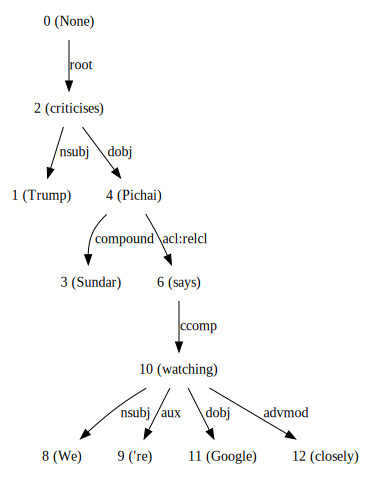

In [30]:
# visualize annotated dependency tree (needs graphviz)
from graphviz import Source
dep_tree_dot_repr = [parse for parse in result][0].to_dot()
source = Source(dep_tree_dot_repr, filename="dep_tree", format="png")
source

# Named Entity Recognition #
In any text document, there are particular terms that represent specific entities that are more informative and have a unique context. These entities are known as named entities , which more specifically refer to terms that represent real-world objects like people, places, organizations, and so on, which are often denoted by proper names. A naive approach could be to find these by looking at the noun phrases in text documents. Named entity recognition (NER) , also known as entity chunking/extraction , is a popular technique used in information extraction to identify and segment the named entities and classify or categorize them under various predefined classes.
<br></br>
SpaCy has some excellent capabilities for named entity recognition. Let’s try and use it on one of our sample news articles.

In [31]:
sentence = str(news_df.iloc[1].full_text)
sentence_nlp = nlp(sentence)

# print named entities in article
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(sentence_nlp, style='ent', jupyter=True)

[(Trump, 'ORG'), (Sundar, 'PERSON'), (Pichai, 'PERSON'), (Google, 'ORG'), (US, 'GPE'), (Donald, 'PERSON'), (Trump, 'PERSON'), (Tuesday, 'DATE'), (Twitter, 'ORG'), (Google, 'ORG'), (Sundar, 'PERSON'), (Pichai, 'PERSON'), (the, 'FAC'), (White, 'FAC'), (House, 'FAC'), (Google, 'ORG'), (Kevin, 'PERSON'), (Cernekee, 'PERSON'), (Google, 'ORG'), (Trump, 'ORG'), (2020, 'DATE'), (US, 'GPE'), (Google, 'ORG'), (Trump, 'ORG')]


We can clearly see that the major named entities have been identified by spacy. To understand more in detail about what each named entity means, you can refer to the [documentation](https://spacy.io/api/annotation#named-entities).

Let’s now find out the most frequent named entities in our news corpus! For this, we will build out a data frame of all the named entities and their types using the following code.

In [0]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])


We can now transform and aggregate this data frame to find the top occuring entities and types.


In [33]:
# get the top named entities
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.iloc[:15,:]

,Entity Name,Entity Type,Frequency
0,India,GPE,25
1,Pakistan,GPE,22
2,US,GPE,21
3,Trump,ORG,12
4,Kashmir,LOC,9
5,Google,ORG,9
6,Facebook,ORG,9
7,China,GPE,9
8,Apple,ORG,8
9,first,ORDINAL,8


We can also group by the entity types to get a sense of what types of entites occur most in our news corpus.

In [34]:
# get the top named entity types
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.iloc[:15,:]

,Entity Type,Frequency
0,ORG,205
1,GPE,161
2,PERSON,144
3,DATE,70
4,CARDINAL,58
5,NORP,39
6,LOC,16
7,ORDINAL,12
8,EVENT,8
9,MONEY,6


[Stanford’s Named Entity Recognizer](https://nlp.stanford.edu/software/CRF-NER.shtml) is based on an implementation of linear chain Conditional Random Field (CRF) sequence models. Unfortunately this model is only trained on instances of PERSON, ORGANIZATION and LOCATION types. Following code can be used as a standard workflow which helps us extract the named entities using this tagger and show the top named entities and their types (extraction differs slightly from **spacy**).

In [35]:
!wget http://nlp.stanford.edu/software/stanford-ner-2014-08-27.zip

--2019-08-10 06:47:07--  http://nlp.stanford.edu/software/stanford-ner-2014-08-27.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/software/stanford-ner-2014-08-27.zip [following]
--2019-08-10 06:47:08--  https://nlp.stanford.edu/software/stanford-ner-2014-08-27.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90379327 (86M) [application/zip]
Saving to: ‘stanford-ner-2014-08-27.zip’

stanford-ner-2014-0 100%[===================>]  86.19M  7.34MB/s    in 33s     

2019-08-10 06:47:41 (2.60 MB/s) - ‘stanford-ner-2014-08-27.zip’ saved [90379327/90379327]



In [36]:
!unzip \stanford-ner-2014-08-27.zip

Archive:  stanford-ner-2014-08-27.zip
   creating: stanford-ner-2014-08-27/
  inflating: stanford-ner-2014-08-27/sample.txt  
  inflating: stanford-ner-2014-08-27/ner-gui.sh  
  inflating: stanford-ner-2014-08-27/ner.bat  
  inflating: stanford-ner-2014-08-27/stanford-ner-3.4.1-javadoc.jar  
   creating: stanford-ner-2014-08-27/classifiers/
  inflating: stanford-ner-2014-08-27/classifiers/english.nowiki.3class.distsim.crf.ser.gz  
  inflating: stanford-ner-2014-08-27/classifiers/english.nowiki.3class.distsim.prop  
  inflating: stanford-ner-2014-08-27/classifiers/english.all.3class.distsim.prop  
  inflating: stanford-ner-2014-08-27/classifiers/english.conll.4class.distsim.crf.ser.gz  
  inflating: stanford-ner-2014-08-27/classifiers/english.muc.7class.distsim.prop  
  inflating: stanford-ner-2014-08-27/classifiers/english.conll.4class.distsim.prop  
  inflating: stanford-ner-2014-08-27/classifiers/english.muc.7class.distsim.crf.ser.gz  
  inflating: stanford-ner-2014-08-27/classifiers

In [37]:
from nltk.tag import StanfordNERTagger
import os

# initialize NER tagger
sn = StanfordNERTagger('stanford-ner-2014-08-27/classifiers/english.all.3class.distsim.crf.ser.gz',
                       path_to_jar='stanford-ner-2014-08-27/stanford-ner.jar')

# tag named entities
ner_tagged_sentences = [sn.tag(sent.split()) for sent in corpus]

# extract all named entities
named_entities = []
for sentence in ner_tagged_sentences:
    temp_entity_name = ''
    temp_named_entity = None
    for term, tag in sentence:
        if tag != 'O':
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

#named_entities = list(set(named_entities))
entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

/usr/local/lib/python3.6/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


In [38]:
# view top entities and types
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head(15)

,Entity Name,Entity Type,Frequency
0,India,LOCATION,25
1,US,LOCATION,21
2,Pakistan,LOCATION,20
3,Kashmir,LOCATION,12
4,Google,ORGANIZATION,10
5,Trump,PERSON,10
6,Facebook,ORGANIZATION,10
7,England,LOCATION,8
8,Huawei,ORGANIZATION,7
9,Donald Trump,PERSON,6


In [39]:
# view top entity types
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head()

,Entity Type,Frequency
0,LOCATION,165
1,PERSON,148
2,ORGANIZATION,121


# Emotion and Sentiment Analysis #
Sentiment analysis is perhaps one of the most popular applications of NLP, with a vast number of tutorials, courses, and applications that focus on analyzing sentiments of diverse datasets ranging from corporate surveys to movie reviews. The key aspect of sentiment analysis is to analyze a body of text for understanding the opinion expressed by it. Typically, we quantify this sentiment with a positive or negative value, called polarity. The overall sentiment is often inferred as positive, neutral or negative from the sign of the polarity score.
<br></br>
Usually, sentiment analysis works best on text that has a subjective context than on text with only an objective context. Objective text usually depicts some normal statements or facts without expressing any emotion, feelings, or mood. Subjective text contains text that is usually expressed by a human having typical moods, emotions, and feelings. Sentiment analysis is widely used, especially as a part of social media analysis for any domain, be it a business, a recent movie, or a product launch, to understand its reception by the people and what they think of it based on their opinions or, you guessed it, sentiment!
<br></br>
Typically, sentiment analysis for text data can be computed on several levels, including on an individual sentence level, paragraph level, or the entire document as a whole. Often, sentiment is computed on the document as a whole or some aggregations are done after computing the sentiment for individual sentences. There are two major approaches to sentiment analysis.
* Supervised machine learning or deep learning approaches
* Unsupervised lexicon-based approaches

Various popular lexicons are used for sentiment analysis, including the following.
* [AFINN lexicon](https://github.com/fnielsen/afinn)
* [Bing Liu’s lexicon](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html)
* [MPQA subjectivity lexicon](http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/)
* [SentiWordNet](http://sentiwordnet.isti.cnr.it/)
* [VADER lexicon](https://github.com/cjhutto/vaderSentiment)
* [TextBlob lexicon](https://github.com/sloria/TextBlob/blob/eb08c120d364e908646731d60b4e4c6c1712ff63/textblob/en/en-sentiment.xml)
<br>

Of course, there are more out there.

# Sentiment Analysis with AFINN Lexicon #
The AFINN lexicon is perhaps one of the simplest and most popular lexicons that can be used extensively for sentiment analysis.

In [40]:
!pip install afinn

     |████████████████████████████████| 61kB 2.5MB/s 
  Created wheel for afinn: filename=afinn-0.1-cp36-none-any.whl size=53453 sha256=5b34168ab2f42574a094c404c7ea27ef93ca6da67af170ffe53ef48c064d1448
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn


In [41]:
# initialize afinn sentiment analyzer
from afinn import Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
    
# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                           
                        count  mean       std   min  25%  50%  75%   max
news_category                                                           
sports                   25.0  0.96  4.334743  -9.0  0.0  1.0  3.0  12.0
technology               25.0 -1.88  4.323579 -11.0 -4.0 -2.0  2.0   6.0
world                    25.0 -1.40  4.974937 -16.0 -4.0 -1.0  1.0   8.0

We can get a good idea of general sentiment statistics across different news categories. Let’s look at some visualizations now.

In [0]:
# Some cool dark background plot
# As I was using dark background
sns.set(style="ticks", context="paper")
plt.style.use("dark_background")

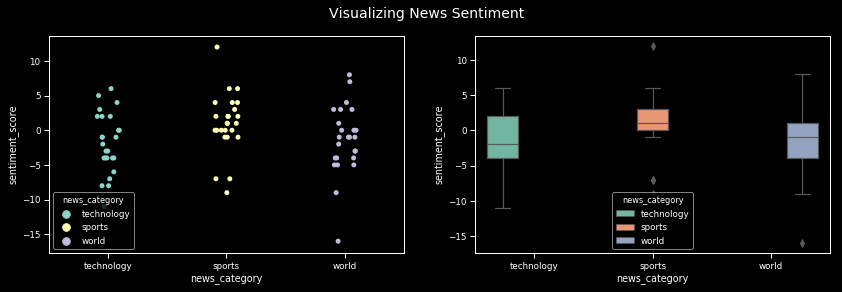

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

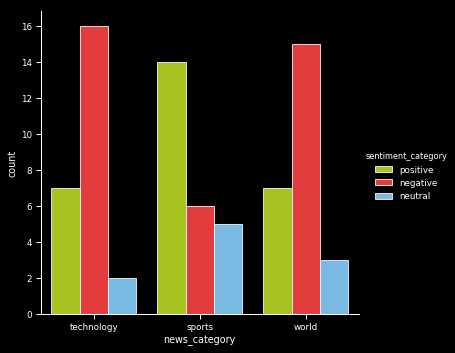

In [44]:
fc = sns.catplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

Let’s dive deeper into the most positive and negative sentiment news articles for technology news.

In [45]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 6)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -11)].index[0]

print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Tech News Article: Facebook has sued two Android app developers on allegations that they made apps available on the Google Play store to infect their users' phones with malware which created fake user clicks on Facebook ads. As a result, the developers generated "unearned payouts", the social media platform alleged. The two developers are Hong Kong-based LionMobi and Singapore-based JediMobi.

Most Positive Tech News Article: Huawei unveiled its own operating system Harmony OS at its Developer Conference in Dongguan, China. The Chinese smartphone maker asserted that the software is ready to be deployed "at any time" if it loses access to Google's Android OS. Google, which was barred from directly carrying out business with Huawei by the US, has temporarily been relieved to do so.


Let’s do a similar analysis for world news.

In [46]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 4)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -16)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: Human rights organisation Amnesty International issued a travel warning for the US on Thursday, citing the recent mass shootings in Ohio and Texas that killed 31 people. The organisation alleges that US government was prioritising gun ownership over basic human rights. The advisory claims travellers' race, country of origin, ethnic background and sexual orientation may put them at risk.

Most Positive World News Article: The US has said that there's no change in its policy on Kashmir and added that it's following the matter closely. "We want to maintain peace and stability, and support direct dialogue between India and Pakistan on Kashmir and other issues of concern," the US said. Notably, the US maintains that Kashmir is a bilateral issue between India and Pakistan.


# Sentiment Analysis with TextBlob #
TextBlob is another excellent open-source library for performing NLP tasks with ease, including sentiment analysis.
<br></br>
Typically, the scores have a normalized scale as compare to Afinn. The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective. Let’s use this now to get the sentiment polarity and labels for each news article and aggregate the summary statistics per news category.

In [47]:
from textblob import TextBlob

# compute sentiment scores (polarity) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]


# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                     ...                     
                        count     mean       std  ...    50%    75%    max
news_category                                     ...                     
sports                   25.0  0.11852  0.207167  ...  0.079  0.180  0.700
technology               25.0  0.00304  0.164694  ...  0.020  0.092  0.367
world                    25.0  0.04952  0.150735  ...  0.050  0.134  0.300

[3 rows x 8 columns]

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


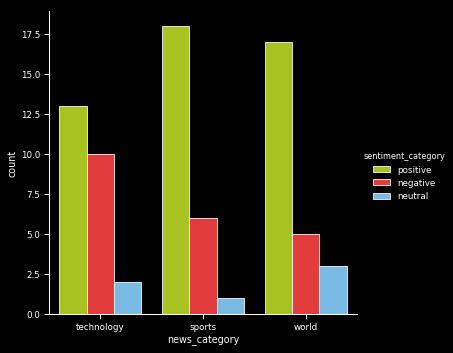

In [48]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [49]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 0.3)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -0.3)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: Pakistan's Railway Minister Sheikh Ahmad has announced the suspension of Thar Express train service to India, a day after announcing the end of the Samjhauta Express service. Thar Express links Jodhpur and Karachi via the Munabao-Khokhrapar border crossing. Pakistan's latest move follows its decision to downgrade diplomatic relations with India after the abrogation of Article 370 on Jammu and Kashmir.

Most Positive World News Article: The US has said that there's no change in its policy on Kashmir and added that it's following the matter closely. "We want to maintain peace and stability, and support direct dialogue between India and Pakistan on Kashmir and other issues of concern," the US said. Notably, the US maintains that Kashmir is a bilateral issue between India and Pakistan.


Finally, we can even evaluate and compare between these two models as to how many predictions are matching and how many are not (by leveraging a confusion matrix which is often used in classification). We leverage our nifty model_evaluation_utils module for this.

In [0]:
from sklearn import metrics
def display_confusion_matrix_pretty(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                labels=level_labels)) 
    return cm_frame    

In [55]:
display_confusion_matrix_pretty(true_labels=sentiment_category, 
                                predicted_labels=sentiment_category_tb, 
                                classes=['negative', 'neutral', 'positive'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  del sys.path[0]


Predicted:                 
                   negative neutral positive
Actual: negative         14       5       18
        neutral           2       0        8
        positive          5       1       22

# Reference #

[Source](https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72)

Prepared by: [Wong Jian Zhi](https://github.com/jianzhiw)